In [1]:
import numpy as np
import pandas as pd
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import scipy.stats as stats
from math import sqrt
from scipy.stats import norm
from statsmodels.stats.diagnostic import acorr_ljungbox


In [2]:
#!pip install kaggle
from google.colab import files
data = files.upload()

Saving Talawakelle Tea Estate Stock Price History.csv to Talawakelle Tea Estate Stock Price History.csv


In [3]:
import pandas as pd
df = pd.read_csv("Talawakelle Tea Estate Stock Price History.csv")
print(df.head())

        Date  Closing Price
0  10/3/2022           98.8
1  10/4/2022           94.5
2  10/5/2022           98.7
3  10/6/2022           98.5
4  10/7/2022          100.0


In [4]:
len(df)

480

In [5]:
# a)
df["time_index"] = range(len(df))  # Starts at 0, increments by 1

In [6]:
df.head()

,Date,Closing Price,time_index
0,10/3/2022,98.8,0
1,10/4/2022,94.5,1
2,10/5/2022,98.7,2
3,10/6/2022,98.5,3
4,10/7/2022,100.0,4


In [7]:
log_returns = np.log(df["Closing Price"]/df["Closing Price"].shift(1)).dropna()

In [8]:
sigma_2 = np.var(log_returns)
mu = np.mean(log_returns) + sigma_2/2

In [9]:
# b)
print(f"Scale parameter: {np.sqrt(sigma_2):.4f}")
print(f"Drift parameter mu: {mu:.4f}")

Scale parameter: 0.0251
Drift parameter mu: 0.0008


In [10]:
# c)
# (A) Normality test
shapiro_stat, p_value = shapiro(log_returns)
print(f"Shapiro-Wilk p-value: {p_value:.4f}")  # p < 0.05 → not normal


Shapiro-Wilk p-value: 0.0000


Shapiro-Wilk p-value of 0.0000 for TPL's log returns provides strong statistical evidence against normality

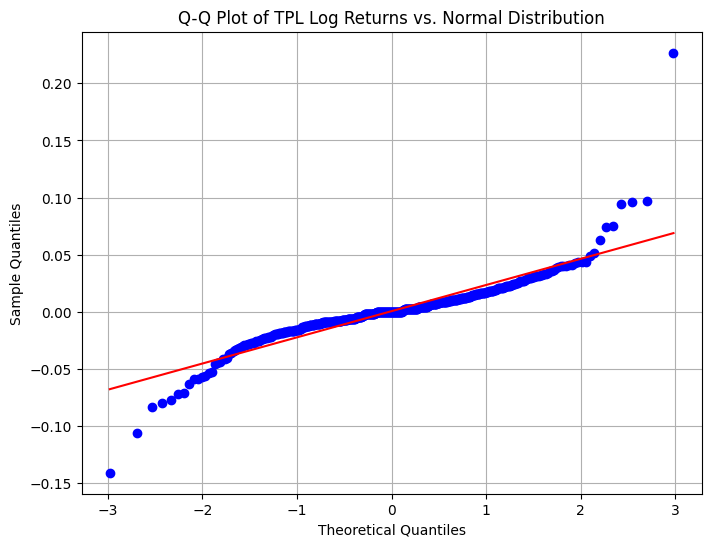

In [11]:
# Generate Q-Q plot
plt.figure(figsize=(8, 6))
stats.probplot(log_returns, dist="norm", plot=plt)
plt.title("Q-Q Plot of TPL Log Returns vs. Normal Distribution")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.grid()
plt.show()

GBM is inappropriate for TPL’s closing prices because:

* GBM assumes log returns are normally distributed, but TPL’s returns violate this.


<Figure size 1000x400 with 0 Axes>

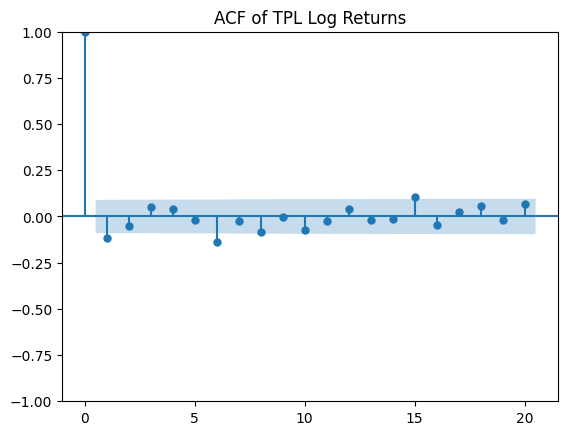

In [12]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(10, 4))
plot_acf(log_returns, lags=20, alpha=0.05, title="ACF of TPL Log Returns")
plt.show()

GBM Assumption Violation:

* GBM requires no autocorrelation (independent increments).

* TPL shows significant autocorrelation at multiple lags → GBM is inappropriate.

Market Behavior Suggested by ACF:

* Positive autocorrelation (Lags 1-5):

  * Short-term momentum (past returns influence future returns).

  * Example: If TPL rose yesterday, it’s likely to rise today.

* Negative autocorrelation (Lags 10-20):

  * Long-term mean reversion (overbought/oversold reversals).

There are two assumptions must
be satisfied for GBM process. There are normality of
the log ratios and the independence from the previous
data.

In [13]:
# Step 2: Apply Ljung-Box Test
lags = 10  # Test autocorrelation up to 10 lags (adjust as needed)
lb_test = acorr_ljungbox(log_returns, lags=lags, return_df=True)

print("Ljung-Box Test Results:")
print(lb_test)

# Step 3: Interpret results
print("\nInterpretation:")
for lag in range(1, lags + 1):
    p_value = lb_test.iloc[lag - 1]['lb_pvalue']
    if p_value < 0.05:
        print(f"Lag {lag}: p-value = {p_value:.4f} → Reject H0 (Dependence detected)")
    else:
        print(f"Lag {lag}: p-value = {p_value:.4f} → Fail to reject H0 (Independence)")

Ljung-Box Test Results:
      lb_stat  lb_pvalue
1    6.798717   0.009122
2    7.981537   0.018486
3    9.261804   0.026005
4    9.955956   0.041176
5   10.166479   0.070653
6   19.283766   0.003710
7   19.565140   0.006590
8   22.989334   0.003378
9   22.993136   0.006212
10  25.753815   0.004086

Interpretation:
Lag 1: p-value = 0.0091 → Reject H0 (Dependence detected)
Lag 2: p-value = 0.0185 → Reject H0 (Dependence detected)
Lag 3: p-value = 0.0260 → Reject H0 (Dependence detected)
Lag 4: p-value = 0.0412 → Reject H0 (Dependence detected)
Lag 5: p-value = 0.0707 → Fail to reject H0 (Independence)
Lag 6: p-value = 0.0037 → Reject H0 (Dependence detected)
Lag 7: p-value = 0.0066 → Reject H0 (Dependence detected)
Lag 8: p-value = 0.0034 → Reject H0 (Dependence detected)
Lag 9: p-value = 0.0062 → Reject H0 (Dependence detected)
Lag 10: p-value = 0.0041 → Reject H0 (Dependence detected)


In [14]:
df.tail()

,Date,Closing Price,time_index
475,9/25/2024,124.75,475
476,9/26/2024,122.00,476
477,9/27/2024,126.50,477
478,9/30/2024,126.25,478
479,10/1/2024,126.25,479


In [15]:
def BrownianG(m, T, N, sigma, mu, w0, GB = False):
  """
    m = Number of sample paths
    T = Total time
    sigma = scale parameter
    N = number of steps
    mu = drift parameter
    wo = initial value

    Return
    ----------
    numpy array of shape (m, N+1), where the first column
    gives the initial values of each path
  """
  # time step
  dt = T/N
  # creating an array to store simulated values
  x = np.zeros((m, N+1))
  # initial values
  x[:, 0] = w0
  x0 = x[:, 0]

  if not GB:
    r = norm.rvs(size=x0.shape + (N,), loc = mu*dt, scale = sigma*sqrt(dt))
    np.cumsum(r, axis=-1, out=x[:, 1:])
    x[:,1:]  += w0

  else:
     r = norm.rvs(size=x0.shape + (N,), loc = mu*dt, scale = sigma*sqrt(dt))
     np.cumsum(r, axis=-1, out=x[:, 1:])

     if w0 != 0:
      x[:,1:] = w0*np.exp(x[:,1:])
     else :
      x[:,1:] = np.exp(x[:,1:])

  return x



In [16]:
m = 10000
T = 20
sigma = np.sqrt(sigma_2)
N = 150
mu = mu
w0 = df["Closing Price"][len(df)-1]
t0 = 0
t1 = df["time_index"][len(df)-1]

y = BrownianG(m,T,N,sigma,mu,w0,True) # Geometric Brownian Motion


In [17]:
y

array([[126.25      , 126.67267003, 127.67827678, ..., 130.96285707,
        130.72393914, 129.83369729],
       [126.25      , 125.20684401, 124.41733096, ..., 155.13470729,
        155.1256528 , 156.18831936],
       [126.25      , 126.2061394 , 126.97011193, ..., 133.80089423,
        134.14789617, 134.62819373],
       ...,
       [126.25      , 125.79563546, 121.92694116, ..., 154.06336581,
        154.4861792 , 157.2477662 ],
       [126.25      , 125.47429945, 127.05041871, ..., 120.36151798,
        121.05609447, 121.16952   ],
       [126.25      , 126.46221737, 125.99733136, ..., 141.18462214,
        140.99243254, 139.21064377]])

In [18]:
def BrownianPlot(y,T):
  """
    Arguments
    -----------
    y-array with shape (m,N+1). Each row gives discritizeed version
    of a sample path.There are m sample paths
    T-Total Time

    Returns
    ----------
    A plot of the sample paths
  """

  # Number of steps
  N = y.shape[1]
  # Length of time step
  dt = T/(N-1)

  t = np.linspace(t1, t1+N*dt, N)
  for k in range(y.shape[0]):
    plt.plot(t,y[k])

  # Set x-axis to show only integer values
  plt.xticks(np.arange(t1, t1+T+1, step=max(1, int(T/10))),  # Ensure at least step=1
               fontsize=12)

  plt.xlabel('Time', fontsize=15)
  plt.ylabel('W_t', fontsize=15)
  plt.title(f'Geometric Brownian Motion from t={t1} to t={t1+T}', fontsize=15)
  #plt.grid(True)
  plt.show()

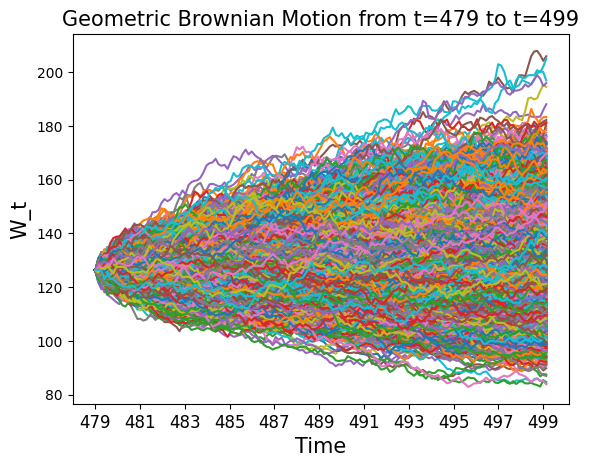

In [19]:
BrownianPlot(y,T)

In [20]:
def BrownianPlot(y,T):
  """
    Arguments
    -----------
    y-array with shape (m,N+1). Each row gives discritizeed version
    of a sample path.There are m sample paths
    T-Total Time

    Returns
    ----------
    A plot of the sample paths
  """
  ht = np.linspace(t0, t1, len(df))

  plt.plot(ht, df["Closing Price"], 'b-', linewidth=2, label='Historical Data')
  # Number of steps
  N = y.shape[1]
  # Length of time step
  dt = T/(N-1)

  t = np.linspace(t1, t1+N*dt, N)
  for k in range(y.shape[0]):
    plt.plot(t,y[k])
  plt.xlabel('Time', fontsize=15)
  plt.ylabel('W_t', fontsize=15)
  plt.show()

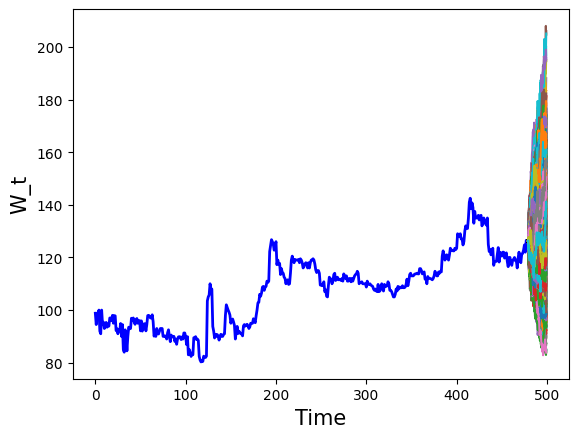

In [21]:
BrownianPlot(y,T)

In [22]:
y.shape

(10000, 151)

In [23]:
def BrownianEnd(y,T,loc):
  """
  Arguments
  ----------
  y-array with shape (m,N+1).Each row gives discritized version
  of a sample path. There are a sample paths
  T-total time
  loc-location of graph

  Returns
  ---------
  A histogram of values which are obtained by discritizing the sample
  paths at the given location
  """

  # Number of steps
  N = y.shape[1]
  # Length of a step
  dt = T/(N-1)
  # The position of the array corresponding to the given location
  pos = int(loc/dt)
  # Histogram
  plt.hist(y[:,pos],bins=25,density=True)
  plt.show()

In [24]:
dfGBM = pd.DataFrame(y.T)
dfGBM

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,126.250000,126.250000,126.250000,126.250000,126.250000,126.250000,126.250000,126.250000,126.250000,126.250000,...,126.250000,126.250000,126.250000,126.250000,126.250000,126.250000,126.250000,126.250000,126.250000,126.250000
1,126.672670,125.206844,126.206139,128.361225,125.390156,124.883703,126.960364,127.238198,125.938008,127.066860,...,126.674046,125.398280,126.005319,126.790284,129.179859,126.764300,127.377662,125.795635,125.474299,126.462217
2,127.678277,124.417331,126.970112,127.541779,125.749357,123.865592,126.876483,126.753180,125.387187,128.827613,...,126.464924,124.490732,125.209892,126.958458,128.703856,125.571633,127.165623,121.926941,127.050419,125.997331
3,127.246133,126.269293,127.326753,127.534841,127.426472,123.329338,126.629078,127.198077,125.982168,129.584509,...,125.984822,124.510551,122.975664,128.478233,129.547152,125.352655,127.348027,123.676832,126.680266,122.978974
4,126.482246,126.991175,126.891232,127.539708,126.647851,124.506600,126.437985,128.051062,126.083914,128.527691,...,126.566703,122.573441,122.377430,128.560553,128.827826,123.377554,128.579424,124.070054,127.734611,124.768927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,132.146625,150.416155,134.925936,135.611157,114.248251,132.932259,121.375042,126.586883,122.823232,118.478621,...,138.095862,126.042860,117.897323,118.199055,144.900649,131.036274,146.411221,156.702362,122.802591,135.453170
147,132.007363,151.982500,133.365923,134.578512,113.793096,131.822258,120.792190,127.400341,122.176559,119.366757,...,140.468782,126.596865,117.965336,116.920017,144.781505,129.938867,145.338794,156.909750,121.811184,138.011205
148,130.962857,155.134707,133.800894,133.077570,113.471369,131.817406,121.772503,129.718973,120.446097,119.101602,...,140.785392,124.900720,117.917887,118.437283,145.609572,128.777437,143.069990,154.063366,120.361518,141.184622
149,130.723939,155.125653,134.147896,133.239576,115.108321,131.922062,121.403117,130.293598,119.673287,119.360885,...,139.634683,124.567758,118.740300,118.249215,144.609132,130.703816,143.534533,154.486179,121.056094,140.992433


In [25]:
endingValueGBM = dfGBM.loc[150] # last row
endingValueGBM.describe()

,150
count,10000.000000
mean,129.259287
std,14.484231
min,83.828975
25%,119.032165
50%,128.511551
75%,138.538687
max,205.980984


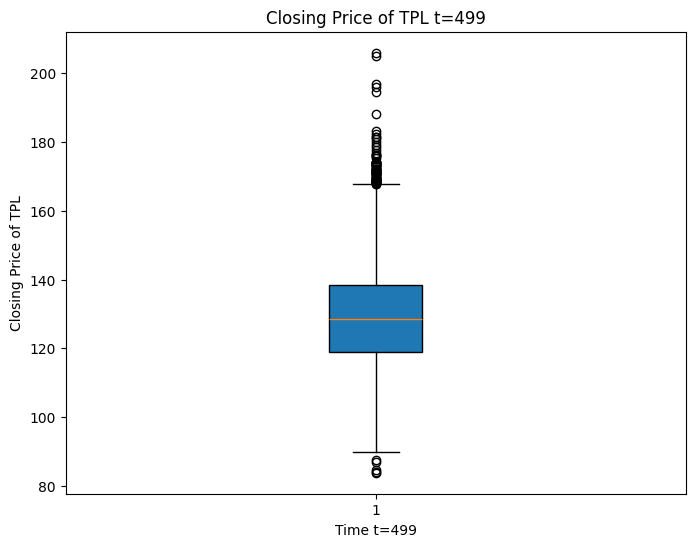

In [26]:
# Create boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(endingValueGBM, patch_artist=True)
plt.title('Closing Price of TPL t=499')
plt.xlabel('Time t=499')
plt.ylabel('Closing Price of TPL')

plt.show()

In [27]:
len(endingValueGBM[(endingValueGBM > 130) & (endingValueGBM < 140)])/len(endingValueGBM)

0.24

In [28]:
# 95% prediction interval for endingValues
np.percentile(endingValueGBM,[2.5,97.5])

array([103.49101265, 159.94688053])